If not yet available some libraries and their python bindings have to be installed :<br>
- gmsh (best installed globally through package management system)
- python3 -m pip install pygmsh --user
- VTK (best installed globally through package management system)
- python3 -m pip install vtk --user

In [26]:
import numpy as np
from scipy import constants
import scipy.integrate
import scipy.special as func
from MeshedFields import *

# Create a meshed screen with a central hole

In [2]:
import pygmsh

Ra = 0.020
Ri = 0.002
lca = 0.002
lci = 0.0002

geom = pygmsh.built_in.Geometry()
# we create the initial geometry as a streched ellipse to create
# different scaling lengths (cell sizes) along the different axes
p1 = geom.add_point([Ra, 0.0, 0.0], lcar=lca)
p2 = geom.add_point([0.0, Ra, 0.0], lcar=lca)
p3 = geom.add_point([-Ra, 0.0, 0.0], lcar=lca)
p4 = geom.add_point([0.0, -Ra, 0.0], lcar=lca)
p1i = geom.add_point([Ri, 0.0, 0.0], lcar=lci)
p2i = geom.add_point([0.0, Ri, 0.0], lcar=lci)
p3i = geom.add_point([-Ri, 0.0, 0.0], lcar=lci)
p4i = geom.add_point([0.0, -Ri, 0.0], lcar=lci)
pc = geom.add_point([0.0, 0.0, 0.0])
pa = geom.add_point([1.0, 0.0, 0.0])
# the mesh is circumscribed with four elliptic arcs
e1 = geom.add_ellipse_arc(start=p1, center=pc, point_on_major_axis=pa, end=p2)
e2 = geom.add_ellipse_arc(start=p2, center=pc, point_on_major_axis=pa, end=p3)
e3 = geom.add_ellipse_arc(start=p3, center=pc, point_on_major_axis=pa, end=p4)
e4 = geom.add_ellipse_arc(start=p4, center=pc, point_on_major_axis=pa, end=p1)
# the hole is circumscribed with four elliptic arcs
e1i = geom.add_ellipse_arc(start=p1i, center=pc, point_on_major_axis=pa, end=p2i)
e2i = geom.add_ellipse_arc(start=p2i, center=pc, point_on_major_axis=pa, end=p3i)
e3i = geom.add_ellipse_arc(start=p3i, center=pc, point_on_major_axis=pa, end=p4i)
e4i = geom.add_ellipse_arc(start=p4i, center=pc, point_on_major_axis=pa, end=p1i)
# these are combined into a line loop
hole = geom.add_line_loop([e1i,e2i,e3i,e4i])
outline = geom.add_line_loop([e1,e2,e3,e4])
geom.add_plane_surface(outline,holes=[hole])
# now we can create the mesh
mesh = pygmsh.generate_mesh(geom, dim=2, verbose=False)
tris = mesh.cells['triangle']
screen = MeshedField(mesh.points,tris)

The screen is placed at the origin. A beam is assumed to propagate in z direction<br>
The screen normal is pointing in the negative z direction.

In [3]:
print("%d points" % len(screen.points))
print("%d triangles" % len(screen.triangles))
area = screen.MeshArea()
normals = screen.MeshNormals()
average = np.sum(normals, axis=0)/screen.Np
print("total mesh area = %7.3f cm²" % (1.0e4*np.sum(area)))
print("screen normal = %s" % average)

1626 points
3120 triangles
total mesh area =  12.421 cm²
screen normal = [ 0.  0. -1.]


In [4]:
screen.ShowMeshedField(showAxes=True)

### define the timing
The beam is assumed to start such that it passes the screen at t=0.

In [5]:
# time step
screen.dt = 2.0e-13
# all points use the same timing grid
screen.Nt = 500
screen.t0 = np.ones(screen.Np)*(-screen.Nt//2*screen.dt)

### Write the file
It is assumed that the script was started from the scripts directory. The file should be created in the tests folder.

In [6]:
filename="../tests/DiffractionScreen.h5"
screen.WriteMeshedField(filename)

not writing ElMagField dataset


### Check the file after running the test

In [80]:
filename = "../tests/DiffractionScreenWithFields.h5"
computed = MeshedField.ReadMeshedField(filename)

print("%d points" % len(computed.points))
print("%d triangles" % len(computed.triangles))
area = computed.MeshArea()
normals = computed.MeshNormals()
average = np.sum(normals, axis=0)/computed.Np
print("total mesh area = %7.3f cm²" % (1.0e4*np.sum(area)))
print("screen normal = %s" % average)

corner points :  (1626, 3)
triangles :  (3120, 3)
Nt = 500   dt = 2e-13 
t0 :  (3120,)
field :  (3120, 500, 6)
1626 points
3120 triangles
total mesh area =  12.421 cm²
screen normal = [ 0.  0. -1.]


In [81]:
area = computed.MeshArea()
S = [np.linalg.norm(computed.EnergyFlowVector(i)) for i in range(computed.Np)]
peak_index = np.argmax(S)
Pz = [computed.NormalEnergyFlow(i) for i in range(computed.Np)]

print("peak energy density = %.6f J/m²  index=%d" % (S[peak_index],peak_index))
print("total pulse energy = %.3f µJ" % (1e6*np.dot(area,Pz)))

peak energy density = 0.019487 J/m²  index=2765
total pulse energy = 0.471 µJ


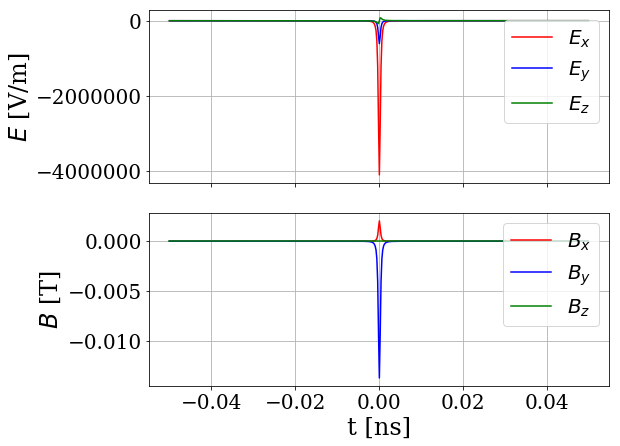

In [82]:
computed.ShowMeshedField(scalars=Pz,scalarTitle="Pz",highlight=[peak_index],showGrid=True)
computed.ShowFieldTrace(peak_index)

cell No. 1670 pos=[ 0.00049878  0.01748992  0.        ]
pointing vector S=[  1.41626690e-10   4.96617747e-09   1.55732651e-04]


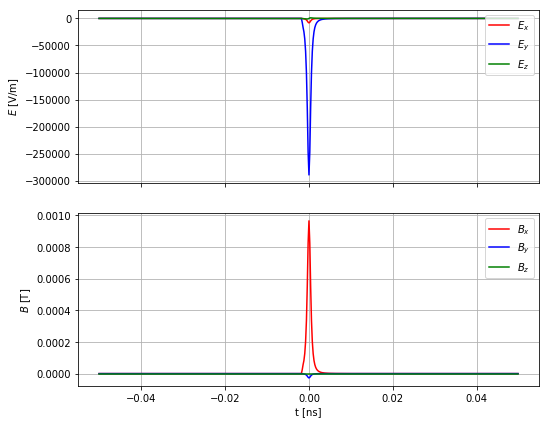

In [37]:
def pick(id):
    if id>0 and id<computed.Np:
        print("cell No. %d pos=%s" % (id,computed.pos[id]))
        print("pointing vector S=%s" % computed.EnergyFlowVector(id))
        computed.ShowFieldTrace(id)

computed.ShowMeshedField(scalars=Pz,scalarTitle="Pz",pickAction=pick,showGrid=False)

In [83]:
t = 3.34e-9
fields = computed.FieldsAtTime(t)
Ex = [f[0] for f in fields]
Ey = [f[1] for f in fields]
computed.ShowMeshedField(scalars=Ey,scalarTitle="Ey",showGrid=False,lut=phaseLUT())

### spectral distribution

### theory
Casalbuoni, Schmidt, Schmüser : TESLA Report 2005-15 : Fig.12

In [84]:
Q = 100.0e-12
N_e = Q / constants.e
N_e_sq = N_e * N_e
γ = 20
β = np.sqrt(1-1/(γ*γ))

ugf_0 = np.power(constants.e,2) /( 4*np.power(np.pi,3)*constants.epsilon_0*constants.c)
def d2Ugf(β,Θ):
    return ugf_0 * (np.power(β,2)*np.power(np.sin(Θ),2))/np.power(1-np.power(β,2)*np.power(np.cos(Θ),2),2)
def T(ω,Θ,a):
    arg1 = ω*a/(β*γ*constants.c)
    arg2 = ω*a*np.sin(Θ)/constants.c
    arg3 = ω*a/(constants.c*np.power(β*γ,2)*np.sin(Θ))
    return arg1*func.j0(arg2)*func.k1(arg1)+arg3*func.j1(arg2)*func.k0(arg1)
def TT(ω,Θ,a1,a2):
    return np.square(T(ω,Θ,a1)-T(ω,Θ,a2))

def angular_integral(ω_i,r_i,r_a):
    def dUdωdΘ(Θ):
        return d2Ugf(β,Θ)*2*np.pi*np.sin(Θ)
    def spect_integrand(Θ):
        return dUdωdΘ(Θ)*TT(ω_i,Θ,r_i,r_a)
    integral = scipy.integrate.quadrature(spect_integrand,0,np.pi/2,tol=1e-40,rtol=1e-6,miniter=20,maxiter=400)
    return integral[0]

f_th = np.power(10.0,np.linspace(-2.0,1.0,300))
th1 = np.array([angular_integral(2*np.pi*f*1e12,0.002,0.030) for f in f_th])*2*np.pi*1e9
E_opt = 1000*N_e_sq * scipy.integrate.trapz(th1,f_th)
print("total pulse energy (100pC) = %g µJ" % E_opt)

total pulse energy (100pC) = 4.62938e-07 µJ


total pulse energy = 0.471997 µJ


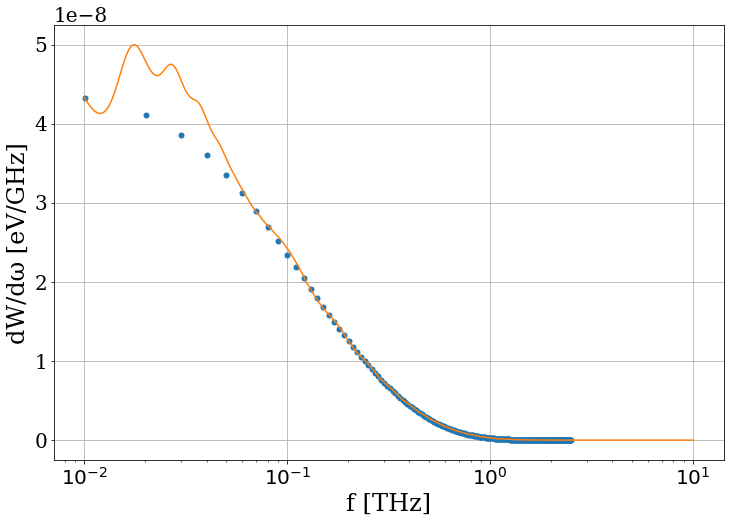

In [85]:
nele = Q/constants.e

nots = computed.Nt
nf = nots
dt = computed.dt
df = 1.0/dt/nf
fmax = 1.0/dt

f = np.linspace(0.0,fmax,nf)[:nots//2]
spectrum = np.zeros(nots//2)

for index in range(computed.Np):
    trace = computed.A[index]
    data = trace.transpose()
    Ex = data[0]
    Ey = data[1]
    Ez = data[2]
    Bx = data[3]
    By = data[4]
    Bz = data[5]
    spectEx = np.fft.fft(Ex)[:nots//2]
    spectEy = np.fft.fft(Ey)[:nots//2]
    spectEz = np.fft.fft(Ez)[:nots//2]
    spectBx = np.fft.fft(Bx)[:nots//2]
    spectBy = np.fft.fft(By)[:nots//2]
    spectBz = np.fft.fft(Bz)[:nots//2]
    amp = np.real(spectEx*np.conj(spectBy)-spectEy*np.conj(spectBx))/constants.mu_0*2*dt/(df*nf)
    spectrum += amp*area[index]

E_opt = scipy.integrate.trapz(spectrum,f)
print("total pulse energy = %g µJ" % (1e6*E_opt))

plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["font.family"] = 'serif'
plt.rcParams["font.size"] = 20
plt.rcParams['axes.labelsize'] = 'large'
fig, ax = plt.subplots()
ax.semilogx(1e-12*f,1e9*spectrum/(nele*nele)/constants.e,marker='.',markersize=10.0,linestyle='None')
ax.semilogx(f_th,th1/constants.e)
ax.set_xlabel('f [THz]')
ax.set_ylabel('dW/dω [eV/GHz]')
ax.grid()